# test goes-orthorectify functions

Orthorectify and clip a GOES ABI image

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import os

In [2]:
import goes_ortho

#### Pick an ABI image and a DEM

In [3]:
image_path =  r'\\j-lundquist-3.ce.washington.edu\storage\GOES\goes16\2017\03\20\ABI-L1b-RadC\18\C14\OR_ABI-L1b-RadC-M3C14_G16_s20170791847510_e20170791850283_c20170791850328.nc'

dem_filename = 'dem\dem2.tif' # local file

### Orthorectify and output new NetCDF file:

#### 1. generate the pixel mapping

In [4]:
pixel_map = goes_ortho.make_ortho_map(image_path, dem_filename)


RUNNING: make_ortho_map()

Opening GOES ABI image...

Get inputs: projection information from the ABI radiance product
...done

Opening DEM file...

Create 2D arrays of longitude and latitude from the DEM
...done

For each grid cell in the DEM, compute the corresponding ABI scan angle (x and y, radians)
...done

Create metadata dictionary about this map
...done

Create pixel map dataset
<xarray.Dataset>
Dimensions:         (latitude: 3600, longitude: 5400)
Coordinates:
  * longitude       (longitude) float64 -120.0 -120.0 -120.0 ... -118.5 -118.5
  * latitude        (latitude) float64 38.5 38.5 38.5 38.5 ... 37.5 37.5 37.5
    dem_px_angle_x  (latitude, longitude) float64 -0.06658 -0.06657 ... -0.06468
    dem_px_angle_y  (latitude, longitude) float64 0.104 0.104 ... 0.102 0.102
Data variables:
    elevation       (latitude, longitude) float64 2.492e+03 ... 1.543e+03
Attributes:
    longitude_of_projection_origin:       -89.5
    semi_major_axis:                      6378137.0
    sem

#### 2. apply to orthorectify an image

In [5]:
ds = goes_ortho.orthorectify_abi_rad(image_path, pixel_map, out_filename='test_ortho.nc')


RUNNING: orthorectify_abi_rad()

Does the projection info in the image match our mapping?

Opening GOES ABI image...			ABI image value	Pixel map value
perspective_point_height + semi_major_axis:	42164160.0	42164160.0
semi_major_axis:				6378137.0	6378137.0
semi_minor_axis:				6356752.31414	6356752.31414
longitude_of_projection_origin:			-89.5		-89.5
...done

Map (orthorectify) and clip the image to the pixel map
...done

Output this result to a new NetCDF file
Saving file as: test_ortho.nc
...done


Try saving this as a geotiff too

In [11]:
!gdal_translate -a_srs EPSG:4326 -of GTiff NETCDF:"C:/Users/steve/git/goes-view/test_ortho.nc":tb "C:/Users/steve/git/goes-view/test_ortho.tif"

Warning 1: Recode from UTF-8 to CP_ACP failed with the error: "Invalid argument".
Warning 1: NetCDF driver detected file type=5, but libnetcdf detected type=3
Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute


Input file size is 5400, 3600
0...10...20...30...40...50...60...70...80...90...100 - done.


#### open the output file and check it out

In [7]:
example_ds = xr.open_dataset('test_ortho.nc')

In [8]:
print(example_ds)

<xarray.Dataset>
Dimensions:         (latitude: 3600, longitude: 5400)
Coordinates:
  * longitude       (longitude) float64 -120.0 -120.0 -120.0 ... -118.5 -118.5
  * latitude        (latitude) float64 38.5 38.5 38.5 38.5 ... 37.5 37.5 37.5
    dem_px_angle_x  (latitude, longitude) float64 ...
    dem_px_angle_y  (latitude, longitude) float64 ...
Data variables:
    elevation       (latitude, longitude) float64 ...
    rad             (latitude, longitude) float32 ...
    tb              (latitude, longitude) float32 ...
Attributes:
    longitude_of_projection_origin:       -89.5
    semi_major_axis:                      6378137.0
    semi_minor_axis:                      6356752.31414
    satellite_height:                     42164160.0
    grs80_eccentricity:                   0.0818191910435
    longitude_of_projection_origin_info:  longitude of geostationary satellit...
    semi_major_axis_info:                 semi-major axis of GRS 80 reference...
    semi_minor_axis_info:       

In [9]:
example_ds.tb.latitude

<xarray.DataArray 'latitude' (latitude: 3600)>
array([38.499861, 38.499583, 38.499306, ..., 37.500694, 37.500417, 37.500139])
Coordinates:
  * latitude  (latitude) float64 38.5 38.5 38.5 38.5 ... 37.5 37.5 37.5 37.5

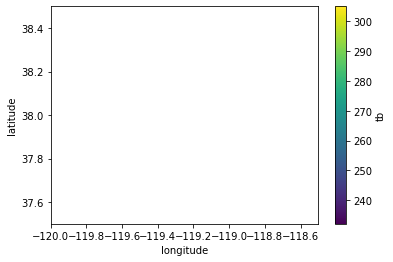

In [10]:
example_ds.tb.plot()